In [30]:
#choose which policy will be applied if deadline is reported (EDF, LLF)
AlgorithmWithDeadline = "LLF";

#choose which policy will be applied if deadline is NOT reported (FIFO, LIFO, LRPT)
AlgorithmWithoutDeadline = "LRPT";


In [2]:
using EVQueues, Plots, Distributions
#using Pkg; Pkg.instantiate()

In [3]:
#Parámetros del resto de la simulación
lambda=100.0;
mu=1;
gamma=1;
C=50.0;
Tfinal=100.0;

#Se agrega snaps para hacer animaciones
#snaps = collect(0.1:0.1:Tfinal);

In [22]:
function hybrid_EDF_FIFO_policy(evs,C)

    if length(evs)==0
        #nothing to do, return empty array for consistence
        U=Array{Float64}(undef,0);
    else
        p=0.0;
        p_fifo=0.0;
        p_edf=0.0;        
        i=1;
        U=zeros(length(evs));
        
        deadlines = [ev.currentReportedDeadline for ev in evs];
        perm = sortperm(deadlines)
        
        #Identifico los VE cuyos deadline no esta reportado
        k=findall(x->x==Inf, deadlines)
        
        if isempty(k)
            ev_edf=perm
        else
            j=findfirst(x->x==k[1], perm)
            #Separo en un nuevo array todos los vehiculos con deadline reportado
            ev_edf=perm[1:j-1]
        end
        
        ratio=length(ev_edf)/length(evs)
        C_edf=ratio*C;
        C_fifo=(1-ratio)*C;
               
        while p_fifo<C_fifo && i<=length(evs)
            if deadlines[i]==Inf
                alloc = min(evs[i].chargingPower,C_fifo-p_fifo);
                p_fifo=p_fifo+alloc;
                U[i]=alloc;
                i=i+1
            else
                i=i+1
            end
        end
        i=1
        while p_edf<C_edf && i<=length(ev_edf)
            alloc = min(evs[perm[i]].chargingPower,C_edf-p_edf);
            p_edf=p_edf+alloc;
            U[perm[i]]=alloc;
            i=i+1
        end
    end
    return U;
end

function hybrid_EDF_LIFO_policy(evs,C)

    if length(evs)==0
        #nothing to do, return empty array for consistence
        U=Array{Float64}(undef,0);
    else
        p=0.0;
        p_lifo=0.0;
        p_edf=0.0;        
        i=length(evs);
        U=zeros(length(evs));
        
        deadlines = [ev.currentReportedDeadline for ev in evs];
        perm = sortperm(deadlines)
        
        #Identifico los VE cuyos deadline no esta reportado
        k=findall(x->x==Inf, deadlines)
        
        if isempty(k)
            ev_edf=perm
        else
            j=findfirst(x->x==k[1], perm)
            #Separo en un nuevo array todos los vehiculos con deadline reportado
            ev_edf=perm[1:j-1]
        end
        
        ratio=length(ev_edf)/length(evs)
        C_edf=ratio*C;
        C_lifo=(1-ratio)*C;
               
        while p_lifo<C_lifo && i>=1
            if deadlines[i]==Inf
                alloc = min(evs[i].chargingPower,C_lifo-p_lifo);
                p_lifo=p_lifo+alloc;
                U[i]=alloc;
                i=i-1;
            else
                i=i-1
            end
        end
        i=1
        while p_edf<C_edf && i<=length(ev_edf)
            alloc = min(evs[perm[i]].chargingPower,C_edf-p_edf);
            p_edf=p_edf+alloc;
            U[perm[i]]=alloc;
            i=i+1
        end
    end
    return U;
end

function hybrid_EDF_LRPT_policy(evs,C)

    if length(evs)==0
        #nothing to do, return empty array for consistence
        U=Array{Float64}(undef,0);
    else
        p=0.0;
        p_lrpt=0.0;
        p_edf=0.0;        
        i=1;
        U=zeros(length(evs));
        
        remaining = [ev.currentWorkload for ev in evs];
        permRemaining = sortperm(remaining,rev=true);
        
        deadlines = [ev.currentReportedDeadline for ev in evs];
        perm = sortperm(deadlines)
        
        #Identifico los VE cuyos deadline no esta reportado
        k=findall(x->x==Inf, deadlines)
        
        if isempty(k)
            ev_edf=perm
        else
            j=findfirst(x->x==k[1], perm)
            #Separo en un nuevo array todos los vehiculos con deadline reportado
            ev_edf=perm[1:j-1]
        end
        
        ratio=length(ev_edf)/length(evs)
        C_edf=ratio*C;
        C_lrpt=(1-ratio)*C;
               
        while p_lrpt<C_lrpt && i<=length(evs)
            if deadlines[i]==Inf
                alloc = min(evs[permRemaining[i]].chargingPower,C_lrpt-p_lrpt);
                p_lrpt=p_lrpt+alloc;
                U[permRemaining[i]]=alloc;
                i=i+1;
            else
                i=i+1
            end
        end
        i=1
        while p_edf<C_edf && i<=length(ev_edf)
            alloc = min(evs[perm[i]].chargingPower,C_edf-p_edf);
            p_edf=p_edf+alloc;
            U[perm[i]]=alloc;
            i=i+1
        end
    end
    return U;
end

function hybrid_LLF_FIFO_policy(evs,C)

    if length(evs)==0
        #nothing to do, return empty array for consistence
        U=Array{Float64}(undef,0);
    else
        p=0.0;
        p_fifo=0.0;
        p_llf=0.0;        
        i=1;
        U=zeros(length(evs));
        
        laxities = [ev.currentReportedDeadline-ev.currentWorkload/ev.chargingPower for ev in evs];
        perm = sortperm(laxities);
        
        #Identifico los VE cuyos deadline no esta reportado
        k=findall(x->x==Inf, laxities)
        
        if isempty(k)
            ev_llf=perm
        else
            j=findfirst(x->x==k[1], perm)
            #Separo en un nuevo array todos los vehiculos con deadline reportado
            ev_llf=perm[1:j-1]
        end
        
        ratio=length(ev_llf)/length(evs)
        C_llf=ratio*C;
        C_fifo=(1-ratio)*C;
               
        while p_fifo<C_fifo && i<=length(evs)
            if laxities[i]==Inf
                alloc = min(evs[i].chargingPower,C_fifo-p_fifo);
                p_fifo=p_fifo+alloc;
                U[i]=alloc;
                i=i+1
            else
                i=i+1
            end
        end
        i=1
        while p_llf<C_llf && i<=length(ev_llf)
            alloc = min(evs[perm[i]].chargingPower,C_llf-p_llf);
            p_llf=p_llf+alloc;
            U[perm[i]]=alloc;
            i=i+1;
        end
    end
    return U;
end

function hybrid_LLF_LIFO_policy(evs,C)

    if length(evs)==0
        #nothing to do, return empty array for consistence
        U=Array{Float64}(undef,0);
    else
        p=0.0;
        p_lifo=0.0;
        p_llf=0.0;        
        i=length(evs);
        U=zeros(length(evs));
        
        laxities = [ev.currentReportedDeadline-ev.currentWorkload/ev.chargingPower for ev in evs];
        perm = sortperm(laxities);
        
        #Identifico los VE cuyos deadline no esta reportado
        k=findall(x->x==Inf, laxities)
        
        if isempty(k)
            ev_llf=perm
        else
            j=findfirst(x->x==k[1], perm)
            #Separo en un nuevo array todos los vehiculos con deadline reportado
            ev_llf=perm[1:j-1]
        end
        
        ratio=length(ev_llf)/length(evs)
        C_llf=ratio*C;
        C_lifo=(1-ratio)*C;
               
        while p_lifo<C_lifo && i>=1
            if laxities[i]==Inf
                alloc = min(evs[i].chargingPower,C_lifo-p_lifo);
                p_lifo=p_lifo+alloc;
                U[i]=alloc;
                i=i-1;
            else
                i=i-1
            end
        end
        i=1
        while p_llf<C_llf && i<=length(ev_llf)
            alloc = min(evs[perm[i]].chargingPower,C_llf-p_llf);
            p_llf=p_llf+alloc;
            U[perm[i]]=alloc;
            i=i+1;
        end
    end
    return U;
end


function hybrid_LLF_LRPT_policy(evs,C)

    if length(evs)==0
        #nothing to do, return empty array for consistence
        U=Array{Float64}(undef,0);
    else
        p=0.0;
        p_lrpt=0.0;
        p_llf=0.0;        
        i=1;
        U=zeros(length(evs));
        
        remaining = [ev.currentWorkload for ev in evs];
        permRemaining = sortperm(remaining,rev=true);
        
        laxities = [ev.currentReportedDeadline-ev.currentWorkload/ev.chargingPower for ev in evs];
        perm = sortperm(laxities);
        
        #Identifico los VE cuyos deadline no esta reportado
        k=findall(x->x==Inf, laxities)
        
        if isempty(k)
            ev_llf=perm
        else
            j=findfirst(x->x==k[1], perm)
            #Separo en un nuevo array todos los vehiculos con deadline reportado
            ev_llf=perm[1:j-1]
        end
        
        ratio=length(ev_llf)/length(evs)
        C_llf=ratio*C;
        C_lrpt=(1-ratio)*C;
               
        while p_lrpt<C_lrpt && i<=length(evs)
            if laxities[i]==Inf
                alloc = min(evs[permRemaining[i]].chargingPower,C_lrpt-p_lrpt);
                p_lrpt=p_lrpt+alloc;
                U[permRemaining[i]]=alloc;
                i=i+1;
            else
                i=i+1
            end
        end
        i=1
        while p_llf<C_llf && i<=length(ev_llf)
            alloc = min(evs[perm[i]].chargingPower,C_llf-p_llf);
            p_llf=p_llf+alloc;
            U[perm[i]]=alloc;
            i=i+1;
        end
    end
    return U;
end

hybrid_LLF_LRPT_policy (generic function with 1 method)

In [31]:
#El 30% de los usuarios no reportan deadline
function no_deadline()
    random = rand()
    if random<0.3
        return Inf
    else
        return 0
    end
end

df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

reportedDeadlines = [d+no_deadline() for d in df[!,:salidas]]
df[!,:salidaReportada] = reportedDeadlines

if (AlgorithmWithDeadline == "EDF") && (AlgorithmWithoutDeadline == "FIFO")
    hybridpolicy = ev_sim_trace(df,hybrid_EDF_FIFO_policy,C,[Inf]);
end

if (AlgorithmWithDeadline == "EDF") && (AlgorithmWithoutDeadline == "LIFO")
    hybridpolicy = ev_sim_trace(df,hybrid_EDF_LIFO_policy,C,[Inf]);
end

if (AlgorithmWithDeadline == "EDF") && (AlgorithmWithoutDeadline == "LRPT")
    hybridpolicy = ev_sim_trace(df,hybrid_EDF_LRPT_policy,C,[Inf]);
end

if (AlgorithmWithDeadline == "LLF") && (AlgorithmWithoutDeadline == "FIFO")
    hybridpolicy = ev_sim_trace(df,hybrid_LLF_FIFO_policy,C,[Inf]);
end

if (AlgorithmWithDeadline == "LLF") && (AlgorithmWithoutDeadline == "LIFO")
    hybridpolicy = ev_sim_trace(df,hybrid_LLF_LIFO_policy,C,[Inf]);
end

if (AlgorithmWithDeadline == "LLF") && (AlgorithmWithoutDeadline == "LRPT")
    hybridpolicy = ev_sim_trace(df,hybrid_LLF_LRPT_policy,C,[Inf]);
end

compute_statistics!(hybridpolicy);

hybridpolicy_evs = sort(hybridpolicy.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
hybridpolicy_evs = hybridpolicy_evs[n:end-n];

Simulando... 100%|██████████████████████████████████████| Time: 0:00:01


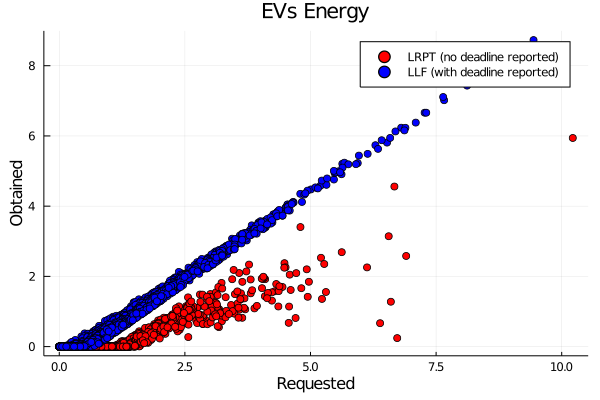

In [32]:
#Guardo resultados de vehiculos
S_hybrid = [ev.requestedEnergy for ev in hybridpolicy_evs];
Sr_hybrid = [ev.departureWorkload for ev in hybridpolicy_evs];
Sa_hybrid = S_hybrid - Sr_hybrid

EVsWithDeadline = [ev.currentReportedDeadline<Inf for ev in hybridpolicy_evs];
EVsWithoutDeadline = [ev.currentReportedDeadline==Inf for ev in hybridpolicy_evs];

p = plot(  xlabel="Requested",
            ylabel="Obtained",
            title="EVs Energy", legend=:topright)

scatter!(p,S_hybrid[EVsWithoutDeadline.==true],Sa_hybrid[EVsWithoutDeadline.==true],markershape=:circle,markersize=4,color=:red,label=AlgorithmWithoutDeadline * " (no deadline reported)")
scatter!(p,S_hybrid[EVsWithDeadline.==true],Sa_hybrid[EVsWithDeadline.==true],markershape=:circle,markersize=4,color=:blue,label=AlgorithmWithDeadline * " (with deadline reported)")

In [33]:
#Compare with policy with deadline
if AlgorithmWithDeadline == "EDF"
    deadlinePolicy = ev_edf_trace(df,C); 
end

if AlgorithmWithDeadline == "LLF"
    deadlinePolicy = ev_llf_trace(df,C); 
end

compute_statistics!(deadlinePolicy);

deadlinePolicy_evs = sort(deadlinePolicy.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
deadlinePolicy_evs = deadlinePolicy_evs[n:end-n];

Simulando... 100%|██████████████████████████████████████| Time: 0:00:00


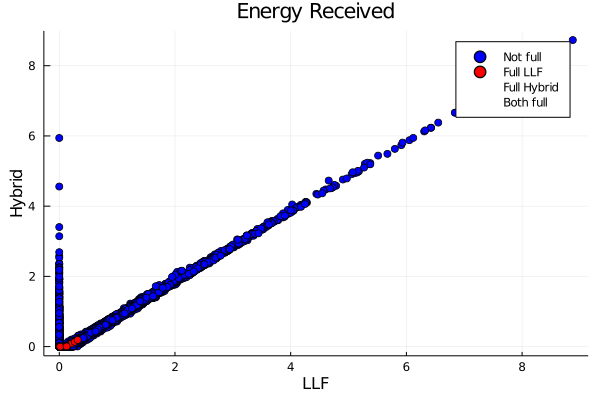

In [34]:
#Guardo resultados de vehiculos
S_deadlinePolicy = [ev.requestedEnergy for ev in deadlinePolicy_evs];
Sr_deadlinePolicy = [ev.departureWorkload for ev in deadlinePolicy_evs];
Sa_deadlinePolicy = S_deadlinePolicy - Sr_deadlinePolicy

full_deadlinePolicy = [ev.departureWorkload==0 for ev in deadlinePolicy_evs];
full_hybrid = [ev.departureWorkload==0 for ev in hybridpolicy_evs];
a=full_deadlinePolicy.*full_hybrid
b=full_deadlinePolicy.+full_hybrid
both_full = [i>0 for i in a];
both_unfull = [i==0 for i in b];

p = plot(  xlabel=AlgorithmWithDeadline,
            ylabel="Hybrid",
            title="Energy Received", legend=:topright)

scatter!(p,Sa_deadlinePolicy[both_unfull.==true],Sa_hybrid[both_unfull.==true],markershape=:circle,markersize=4,color=:blue,label="Not full")
scatter!(p,Sa_deadlinePolicy[full_deadlinePolicy.==true],Sa_hybrid[full_deadlinePolicy.==true],markershape=:circle,markersize=4,color=:red,label="Full "*AlgorithmWithDeadline)
scatter!(p,Sa_deadlinePolicy[full_hybrid.==true],Sa_hybrid[full_hybrid.==true],markershape=:circle,markersize=4,color=:yellow,label="Full Hybrid")
scatter!(p,Sa_deadlinePolicy[both_full.==true],Sa_hybrid[both_full.==true],markershape=:circle,markersize=4,color=:black,label="Both full")

In [35]:
#Compare with Policy Without Deadline
if AlgorithmWithoutDeadline == "FIFO"
    noDeadlinePolicy = ev_fifo_trace(df,C);;
end

if AlgorithmWithoutDeadline == "LIFO"
    noDeadlinePolicy = ev_lifo_trace(df,C);; 
end

if AlgorithmWithoutDeadline == "LRPT"
    noDeadlinePolicy = ev_lrpt_trace(df,C);; 
end

compute_statistics!(noDeadlinePolicy);

noDeadlinePolicy_evs = sort(noDeadlinePolicy.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
noDeadlinePolicy_evs = noDeadlinePolicy_evs[n:end-n];

Simulando... 100%|██████████████████████████████████████| Time: 0:00:00


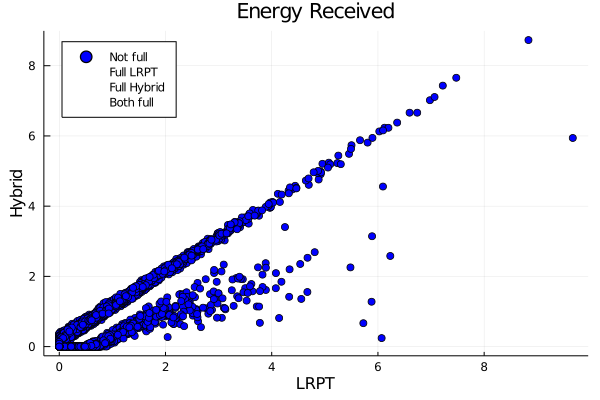

In [36]:
#Guardo resultados de vehiculos
S_noDeadlinePolicy = [ev.requestedEnergy for ev in noDeadlinePolicy_evs];
Sr_noDeadlinePolicy = [ev.departureWorkload for ev in noDeadlinePolicy_evs];
Sa_noDeadlinePolicy = S_noDeadlinePolicy - Sr_noDeadlinePolicy

full_noDeadlinePolicy = [ev.departureWorkload==0 for ev in noDeadlinePolicy_evs];
full_hybrid = [ev.departureWorkload==0 for ev in hybridpolicy_evs];
a=full_noDeadlinePolicy.*full_hybrid
b=full_noDeadlinePolicy.+full_hybrid
both_full = [i>0 for i in a];
both_unfull = [i==0 for i in b];

p = plot(  xlabel=AlgorithmWithoutDeadline,
            ylabel="Hybrid",
            title="Energy Received", legend=:topleft)

scatter!(p,Sa_noDeadlinePolicy[both_unfull.==true],Sa_hybrid[both_unfull.==true],markershape=:circle,markersize=4,color=:blue,label="Not full")
scatter!(p,Sa_noDeadlinePolicy[full_noDeadlinePolicy.==true],Sa_hybrid[full_noDeadlinePolicy.==true],markershape=:circle,markersize=4,color=:red,label="Full "*AlgorithmWithoutDeadline)
scatter!(p,Sa_noDeadlinePolicy[full_hybrid.==true],Sa_hybrid[full_hybrid.==true],markershape=:circle,markersize=4,color=:yellow,label="Full Hybrid")
scatter!(p,Sa_noDeadlinePolicy[both_full.==true],Sa_hybrid[both_full.==true],markershape=:circle,markersize=4,color=:black,label="Both full")

In [37]:
println("Hybrid Policy avg unfinished work: " * string(100*hybridpolicy.stats.avgW)*" %";) 
println(AlgorithmWithDeadline * " Policy avg unfinished work: " * string(100*deadlinePolicy.stats.avgW)*" %";) 
println(AlgorithmWithoutDeadline * " Policy avg unfinished work: " * string(100*noDeadlinePolicy.stats.avgW)*" %";) 

Hybrid Policy avg unfinished work: 50.363129407886994 %
LLF Policy avg unfinished work: 47.664876022657346 %
LRPT Policy avg unfinished work: 48.054162720662234 %
